# **Determining support for Rumours using NLP & Deep Learning**
Social Media is getting popular day by day as it’s able to reach a greater number of people after the easy access to mobile phones and internet. Spread of fake news on these sites are also becoming very prevalent to spread misinformation and promote propaganda. Hence, it’s very important to detect this misinformation. Data Science techniques can be used to detect it. Twitter and Reddit dataset contains tweets, comments, and replies in a data frame that has 4 classes determining the veracity of the rumours. This can help in reducing the impact of the spread of misinformation. To accomplish this task, we must figure out if the comments made about a given post (by other individuals on a given platform) support, deny, query or comment. 

## Dataset
The twitter dataset consists of 6634 rows and 6 columns and reddit dataset contains 2471 rows and 6 columns. 

1. Type - (Categorical: Source, Reply)
2. Msg_ID - Unique id for the message (Numerical)
3. Source_Msg_ID - Msg ID of the source (Numerical)
4. Text - Tweet (Categorical)
5. Topic - Topic of the tweet
6. Class (Target Variable) - Sentiment of the reply (Categorical: query, comment, deny, support)

## Objective
Our aim is to predict the veracity of the response tweets into one of the 4 categories.


In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.8 MB/s 


In [ ]:
!pip install nltk

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/DeepLearning/ruwanten-rmit-cosc2779-2150-119684695345.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/DeepLearning/')

# Importing Libraries and Reading files

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
import pathlib
import shutil
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Embedding, LSTM, Dense,Bidirectional,GRU
from keras.models import Model
import tempfile
from sklearn.model_selection import train_test_split
from  IPython import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from nltk.corpus import stopwords
import tensorflow_addons as tfa
import nltk
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/twitter_dataset.csv')

In [ ]:
extra_data = pd.read_csv('/content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/Extra_reddit_dataset.csv')

In [ ]:
data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.810630e+17,-1.000000e+00,#4U9525: Robin names Andreas Lubitz as the cop...,germanwings-crash,-1
1,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,query
2,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,comment
3,Source,5.813860e+17,-1.000000e+00,RT @khjelmgaard: German media reporting #Andre...,germanwings-crash,-1
4,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment


In [ ]:
data.shape

(6634, 6)

In [ ]:
extra_data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,63uefi,-1,Donald Trump's travel expenses in 10 weeks cos...,None,-1
1,Reply,dfx7l1a,63uefi,But he was from 2001-2009? I don't get what di...,None,comment
2,Reply,dfx88qg,63uefi,Cheney resigned as CEO of Halliburton on July ...,None,comment
3,Reply,dfx3i17,63uefi,[deleted],None,comment
4,Reply,dfx4yef,63uefi,"That is literally not a source, that is Niamh ...",None,comment


In [ ]:
extra_data.shape

(2471, 6)

# EDA

## Barplot
Used to check the distribution of classes of the target variable.

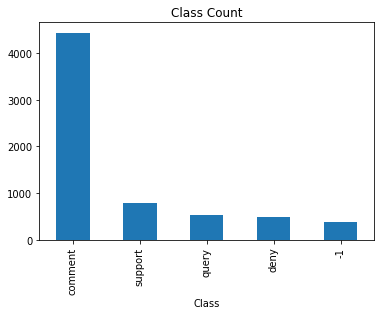

In [ ]:
ax = data.Class.value_counts(normalize=False).plot.bar()
plt.xlabel('Class')
plt.title('Class Count')
plt.show()

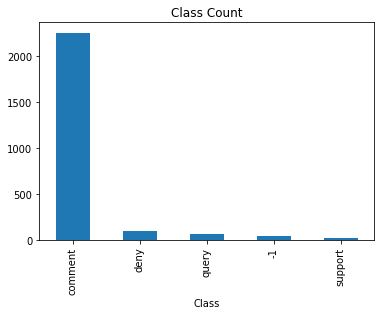

In [ ]:
ax = extra_data.Class.value_counts(normalize=False).plot.bar()
plt.xlabel('Class')
plt.title('Class Count')
plt.show()

### Observation
- There is a very huge class imbalance in the dataset. Target variable with ‘comment’ type has approx. 9 times more observations than the second most frequent class i.e., ‘support’. 
- The number of observations for the minority classes i.e., support, deny and query (which are more contributing in assessing veracity) are very less to obtain very good results from training.

# Data Pre-Processing & Transformation
- Both the datasets have been merged to have more data to train on. 
- Value_Counts() function was used on the text column to check if there are any duplicates and all the duplicates have been removed while making sure that no ‘Source’ message gets deleted.
- All the rows with ‘deleted’ and ‘removed’ texts have been dropped.
- There were some texts which were classified multiple labels. They were deleted because they might diminish the performance of the model as model wouldn’t able to recognize which one is actually right.
- All the words were lower cased so that capital letter words and small letter words aren’t considered different.
- All the website links were deleted because it doesn’t add any value to the predictions. 
- All the special characters like smileys, question marks, full stops, colon, etc. and digits have been removed as they don’t add any meaning to a sentence.
- All the characters with the length of 1 was deleted because there are no adjectives in one letter that can help us distinguishing different sentences.
- All the rows with empty texts have been deleted.

In [ ]:
# merging both the datasets
merged_data = pd.concat([data, extra_data],ignore_index=True)

In [ ]:
merged_data.shape

(9105, 6)

In [ ]:
# checking if there are duplicate rows in Text column
merged_data['Text'].value_counts()

[deleted]                                                                                                                                                              119
Yes, because releasing the actual cost broken down would be a terrible political move for Trump. Why would he just randomly tell everyone how much the trips cost?      10
[removed]                                                                                                                                                               10
Some overhyped actor, probably xD                                                                                                                                       10
Batman, you don't provide a quotation in which the author refutes Blackmore.  Yes, she says the events can be duplicated other ways **but not the sequence.**           10
                                                                                                                                                 

In [ ]:
# deleting rows with deleted or removed texts
merged_data = merged_data[merged_data.Text != '[deleted]']
merged_data = merged_data[merged_data.Text != '[removed]']

In [ ]:
# dowloading stopwords from nltk
nltk.download('stopwords')
stop = stopwords.words('english')
stop.remove('not')
stop.remove('no')
for word in stop:
  if("n'" in word):
    stop.remove(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import string
# converting everything to lower
merged_data['Text'] = merged_data['Text'].apply(lambda x: x.lower())
# removing usernames starting from @
merged_data['Text'] = merged_data['Text'].apply((lambda x: re.sub('(@[a-z]+)','',x)))
# removing links
merged_data['Text'] = merged_data['Text'].apply((lambda x: re.sub('(https?:\/\/.*?)(?:\s|$)','',x)))
# removing everything other than alphabets and spaces
merged_data['Text'] = merged_data['Text'].apply((lambda x: re.sub('[^a-zA-Z\s]','',x)))
# removing stopwords
merged_data['Text'] = merged_data['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
# removing single characters
merged_data['Text'] = merged_data['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if len(word) > 1))

In [ ]:
merged_data['Text'].value_counts()

                                                                                                       209
thanks                                                                                                  12
several hostages freed jewish supermarket paris photo thomas samson afp                                 12
gt year olds join armed forces allow vote year olds cant deployed warzone no                            10
batman dont provide quotation author refutes blackmore yes says events duplicated ways not sequence     10
                                                                                                      ... 
think plan along get across finish line others governing                                                 1
reported hostage takers stated devices planted around cbd precaution                                     1
correct stealing no good sure jail sentence fine wouldve justified not death sentence                    1
mam get dm mams contact number teleph

In [ ]:
# checking texts with just empty string
merged_data[merged_data['Text'] == ''].index

Int64Index([   2,  361,  362,  366,  367,  473,  505,  522,  540,  554,
            ...
            7510, 7558, 7587, 7735, 8289, 8302, 8316, 8325, 9001, 9020],
           dtype='int64', length=209)

In [ ]:
# fill NAN inplace of empty strings
merged_data['Text'].replace('', np.nan, inplace=True)

In [ ]:
merged_data.isnull().values.sum()

209

In [ ]:
# dropping rows with NAN values
merged_data = merged_data.dropna()

In [ ]:
merged_data.shape

(8767, 6)

In [ ]:
# checking for duplicates in Text column while keeping the first occurrence
duplicateRowsDF = merged_data[merged_data.duplicated('Text', keep='first')] 

In [ ]:
duplicateRowsDF

In [ ]:
# duplicateRowsDF.to_excel('/content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/duplicateRowsDF.xlsx', sheet_name = "NewSheet1")

In [ ]:
# filtering out duplicates other than Source type
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['Type'] != "Source"]

In [ ]:
# removing duplicates
merged_data= merged_data[merged_data.apply(lambda x: x.values.tolist() not in duplicateRowsDF.values.tolist(), axis=1)]

In [ ]:
merged_data = merged_data.reset_index(drop=True)

In [ ]:
merged_data

In [ ]:
# merged_data.to_excel('/content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/merged.xlsx', sheet_name = "NewSheet1")

In [ ]:
# checking for sources which only have replies belonging to 'comment' type

valid_source = []
total_source = []
sourceId = 0
for index, row in merged_data.iterrows():
  if (row['Type'] == 'Source'):
    sourceId = row['Msg_ID']
    total_source.append(sourceId)
    text = row['Text']
  if (sourceId == row['Source_Msg_ID']):
    if (row['Class'] == 'deny' or row['Class'] == 'query' or row['Class'] == 'support'):
      if (sourceId not in valid_source):
        valid_source.append(sourceId)

In [ ]:
# checking for texts belonging to sources which only have replies belonging to 'comment' type

invalid_text = []
for index, row in merged_data.iterrows():
  if (row['Type'] == "Source"):
    sourceId = row['Msg_ID']
  if (sourceId == row['Source_Msg_ID']):
    if (row['Class'] == 'comment'):
      if (sourceId not in valid_source):
        text = row['Text']
        invalid_text.append(text)

 

In [ ]:
# total number of sources
len(total_source)

421

In [ ]:
# total number of sources which has query, support, deny along with comment class
len(valid_source)

318

In [ ]:
len(invalid_text)

363

In [ ]:
# adding source to a list and map it to its replies
source = []
text_combined = []
for index, row in merged_data.iterrows():
  if (row['Type'] == "Source"):
    sId = row['Msg_ID']
    source_text = row['Text']
  if (sId == row['Source_Msg_ID']):
    source.append(source_text)

In [ ]:
len(source)

6263

In [ ]:
# removing Source rows
final_data = merged_data.drop(merged_data.loc[merged_data['Class']=='-1'].index)
final_data = final_data.reset_index(drop=True)

In [ ]:
# adding source column and mapping it with its text
final_data['Source'] = source

In [ ]:
final_data.head()

In [ ]:
final_data.shape

(6263, 7)

In [ ]:
final_df = final_data

In [ ]:
# final_df = final_data.drop(final_data[final_data.Text.isin(invalid_text)].index.tolist())
# final_df = final_df.reset_index(drop=True)

In [ ]:
final_df.shape

(6263, 7)

In [ ]:
# encoding class variable
encoder = LabelEncoder()
final_df.insert(2,'Class_Encoded',encoder.fit_transform(final_df['Class']))

In [ ]:
final_df.head()

,Type,Msg_ID,Class_Encoded,Source_Msg_ID,Text,Topic,Class,Source
0,Reply,5.8107e+17,2,5.81063e+17,named pilot,germanwings-crash,query,robin names andreas lubitz copilot flight deck...
1,Reply,5.81576e+17,0,5.81386e+17,fphantom crash mph hit concretewall dred,germanwings-crash,comment,rt german media reporting andreaslubitz seriou...
2,Reply,5.82048e+17,0,5.81386e+17,ers link prove intentionally set kill,germanwings-crash,comment,rt german media reporting andreaslubitz seriou...
3,Reply,5.82206e+17,0,5.81386e+17,sure germanwings copilot andreaslubitz newmoti...,germanwings-crash,comment,rt german media reporting andreaslubitz seriou...
4,Reply,5.81573e+17,0,5.81386e+17,andreaslubitz germanwings dred splitup girlfri...,germanwings-crash,comment,rt german media reporting andreaslubitz seriou...


In [ ]:
final_df['Class'].value_counts()

comment    4550
support     675
query       520
deny        518
Name: Class, dtype: int64

In [ ]:
final_data['Class'].value_counts()

comment    4550
support     675
query       520
deny        518
Name: Class, dtype: int64

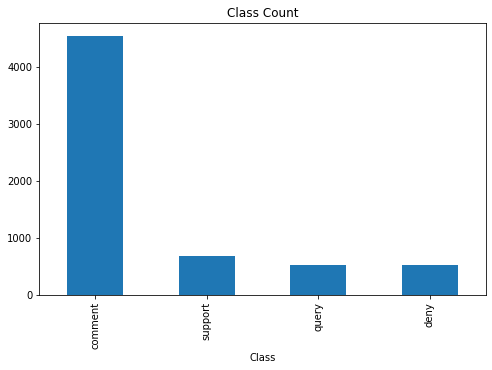

In [ ]:
# Bar plot for checking frequency of each class
plt.figure(figsize=(8,5))
ax = final_df.Class.value_counts(normalize=False).plot.bar()
plt.xlabel('Class')
plt.title('Class Count')
plt.show()

In [ ]:
# final_df.to_excel('/content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/preprocessed.xlsx', sheet_name = "NewSheet1")

# Learning Curve Plot for Performance Visualization

In [ ]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  plt.figure(figsize=(12,8))
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Early Stopping

In [ ]:
# early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Generating task vocabulary 
- All the rows of ‘Source’ and ‘Reply’ have been tokenized and converted into sequences using the same Tokenizer() object so that we have common vocabulary for both the columns.
- Vocabulary size of 11024 was obtained.
- The padding of 55 has been done to each of the text row after looking at the boxplot of length of the sentences.
- One hot Encoding of the target variable has been done since the model accepts that.

In [ ]:
# tokenizing and generating sequence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_df['Source'].values)
X1 = tokenizer.texts_to_sequences(final_df['Source'].values)
tokenizer.fit_on_texts(final_df['Text'].values)
X2 = tokenizer.texts_to_sequences(final_df['Text'].values)

In [ ]:
word_index = tokenizer.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

unique tokens - 11023
vocab_size - 11024


In [ ]:
sent_length = []
for row in X2:
  sent_length.append(len(row))

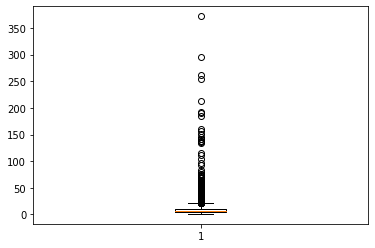

In [ ]:
plt.boxplot(sent_length)
plt.show()

In [ ]:
X1 = pad_sequences(X1,maxlen= 55)
X2 = pad_sequences(X2,maxlen= 55)

In [ ]:
X1[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  205,
        286,  131,  313, 1119,   48,  580,  505,  506,  531,  727,   39],
      dtype=int32)

In [ ]:
X2[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 5238,  645, 5239, 1149, 5240, 2317],
      dtype=int32)

In [ ]:
X1.shape

(6263, 55)

In [ ]:
X2.shape

(6263, 55)

In [ ]:
Y = pd.get_dummies(final_df['Class_Encoded'])

In [ ]:
Y.shape

(6263, 4)

# Data Splitting
Data was split into 3 parts- training, validation, and test. Since there is class imbalance, stratified sampling of ‘class’ type has been done to ensure there are equal proportion of each ‘class’ type in all the splits.

In [ ]:
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size = 0.2, stratify=Y)
X1_train, X1_val, X2_train, X2_val, Y_train, Y_val = train_test_split(X1_train, X2_train,  Y_train, test_size = 0.25, stratify = Y_train)

In [ ]:
print(X1_train.shape,Y_train.shape)
print(X2_train.shape,Y_train.shape)
print(X1_val.shape,Y_val.shape)
print(X2_val.shape,Y_val.shape)
print(X1_test.shape,Y_test.shape)
print(X2_test.shape,Y_test.shape)

(3757, 55) (3757, 4)
(3757, 55) (3757, 4)
(1253, 55) (1253, 4)
(1253, 55) (1253, 4)
(1253, 55) (1253, 4)
(1253, 55) (1253, 4)


In [ ]:
Y_test = Y_test.idxmax(axis=1)

# Performance Metric
- For this task, the priority was given to the ‘support’, ‘deny’ and ‘query’ class of the target variable.
- Macro-averaged F1 score was used as one of our primary performance evaluation metrics to give equal importance to all the classes of both the target variables.
- But since ‘comment’ class is not contributive to the veracity of the replies, less preference was given to this class. F1 also gives good balance between precision and recall. 
- Accuracy was used to determine the amount of overfitting.
- Classification Report and Confusion Matrix were used to determine the performance of the model on test unseen data.

In [ ]:
# method for setting performance metric
def set_metric():
  METRICS = [tfa.metrics.F1Score(num_classes=4,average='macro'), tf.keras.metrics.CategoricalAccuracy(name='accuracy'),]
  return METRICS

In [ ]:
# method for plotting confusion matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# Modelling
- After carefully analysing different modelling techniques like RNN, LSTM, GRU and Transformer based models, LSTM was selected as the final model because of its simplicity. 
- Recurrent Neural Network (RNN) is meant to have long term memory for sequence-based problems such as text classification but in real scenario, it doesn’t have long term memory because of the vanishing gradients problem. 
- Long Short-Term Memory (LSTM) encounters this problem by implementing forget gate which removes information that’s not useful for the prediction and only holds the information that is relevant.

## No Transfer Learning

### Baseline Model
- Multiple input model was created to incorporate sources and replies, and same embedding has been shared between both so that source and replies are represented by the same set of features.
- The embedding dimension has been chosen by experimenting different values in the range 25-150 and the best one turned out to be 50 for this problem as our data corpus is not quite huge.
- Adam optimizer has been used for model compilation. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. 

In [ ]:
# learning rate decay scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
embedding_dim = 50

source_input= Input(shape=(X1_train.shape[1]), name='source_input')
reply_input = Input(shape=(X2_train.shape[1]), name='reply_input')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length = X1_train.shape[1] , trainable=True)

x1 = embedding_layer(reply_input)
x2 = embedding_layer(source_input)

x = tf.keras.layers.concatenate([x1, x2])

# x = GRU(64, return_sequences=True)(x)
x = LSTM(32, return_sequences=False)(x)

out = Dense(4, activation='softmax', name='output')(x)

model_BL = Model(inputs=[reply_input, source_input], outputs=[out])

model_BL.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=set_metric())
print(model_BL.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_input (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
source_input (InputLayer)       [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 55, 50)       551200      reply_input[0][0]                
                                                                 source_input[0][0]               
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 55, 100)      0           embedding_5[0][0]          

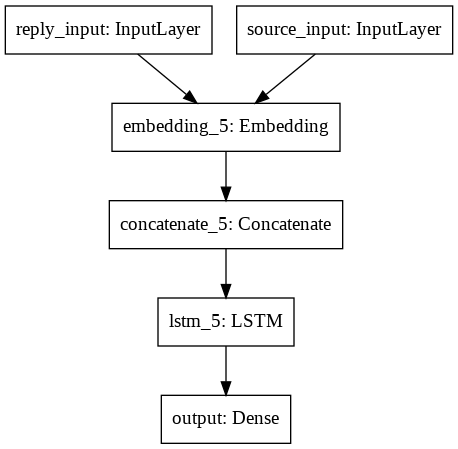

In [ ]:
tf.keras.utils.plot_model(model_BL)

In [ ]:
batch_size = 32
m_histories = {}

In [ ]:
m_histories['BL'] =  model_BL.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = 30, batch_size=batch_size, callbacks= [early_stopping])

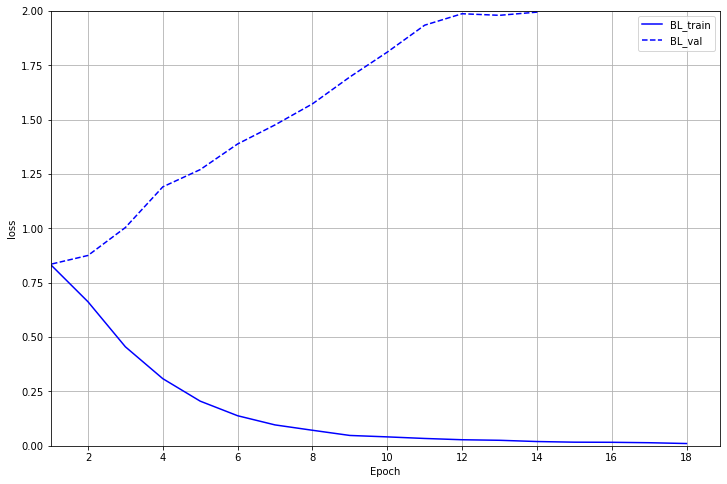

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

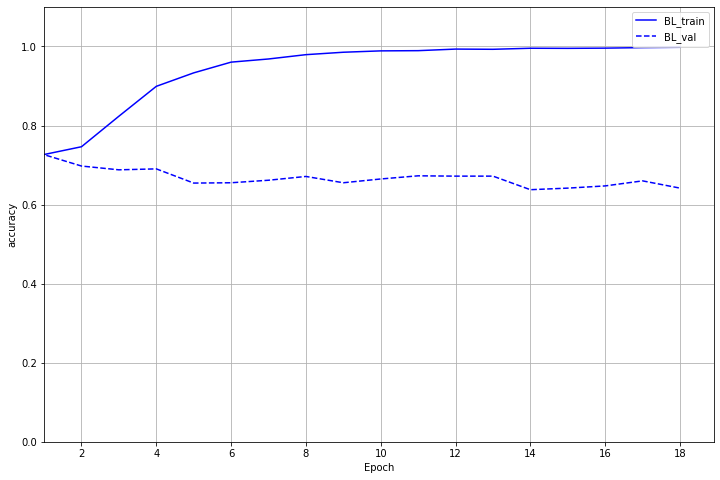

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [ ]:
Y_pred_BL = model_BL.predict([X1_test,X2_test])
Y_pred_BL = np.argmax(Y_pred_BL, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_BL))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       910
           1       0.33      0.20      0.25       104
           2       0.15      0.11      0.12       104
           3       0.25      0.21      0.23       135

    accuracy                           0.66      1253
   macro avg       0.37      0.34      0.35      1253
weighted avg       0.62      0.66      0.63      1253



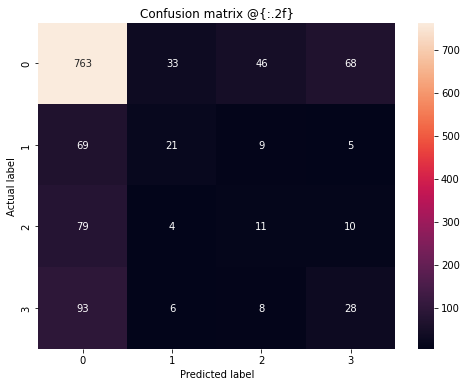

In [ ]:
plot_cm(Y_test,Y_pred_BL)

#### Observation
- The model's performance and generalizability power is really low as we can see the effect of imabalanced class. 'Comment' class is getting over-predicted.
- The amount of overfitting is also huge because of less number of observations of minority class.

### Baseline Model with DropOut
- Used to prevent overfitting.
- Randomly sets input units of outgoing edges to 0.

In [ ]:
embedding_dim = 64

source_input= Input(shape=(X1_train.shape[1]), name='source_input')
reply_input = Input(shape=(X2_train.shape[1]), name='reply_input')

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, input_length = X1_train.shape[1] , trainable=True)

x1 = embedding_layer(reply_input)
x2 = embedding_layer(source_input)
x = tf.keras.layers.concatenate([x1, x2])
x = SpatialDropout1D(0.2)(x)
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)

out = Dense(4, activation='softmax', name='output')(x)
model_drop = Model(inputs=[reply_input, source_input], outputs=[out])
model_drop.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=set_metric())
print(model_drop.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reply_input (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
source_input (InputLayer)       [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 55, 64)       705536      reply_input[0][0]                
                                                                 source_input[0][0]               
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 55, 128)      0           embedding_6[0][0]          

In [ ]:
m_histories['drop'] =  model_drop.fit([X1_train,X2_train], [Y_train], validation_data=([X1_val,X2_val], [Y_val]), epochs = 30, batch_size=batch_size, callbacks= [early_stopping])

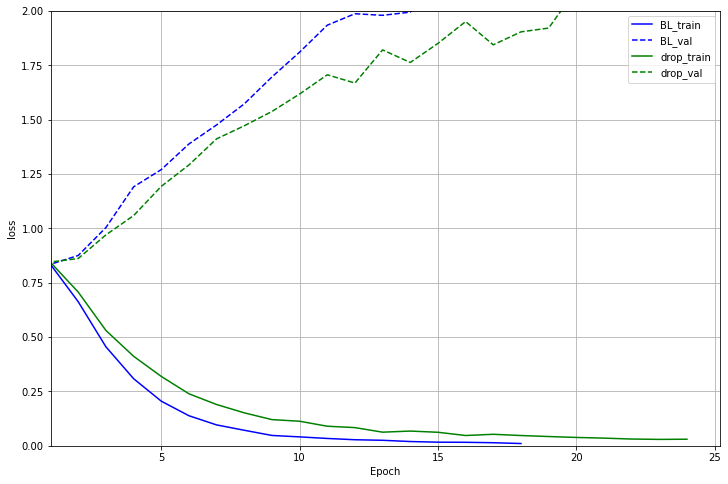

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

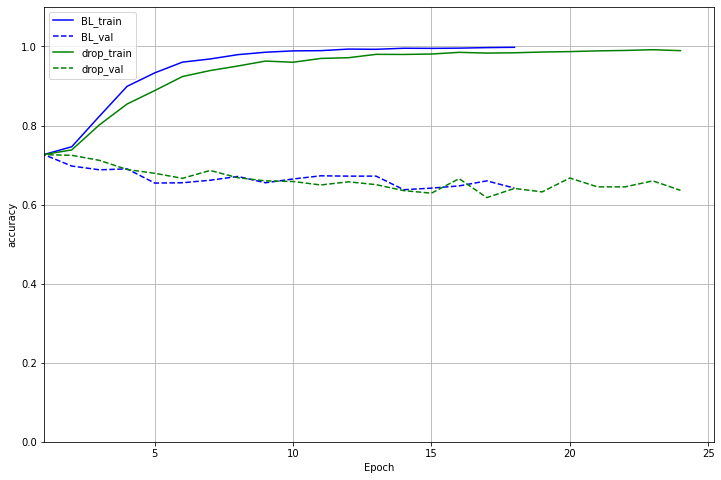

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [ ]:
Y_pred_drop = model_drop.predict([X1_test,X2_test])
Y_pred_drop = np.argmax(Y_pred_drop, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_drop))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       910
           1       0.30      0.19      0.23       104
           2       0.19      0.14      0.16       104
           3       0.23      0.27      0.24       135

    accuracy                           0.63      1253
   macro avg       0.37      0.35      0.36      1253
weighted avg       0.62      0.63      0.63      1253



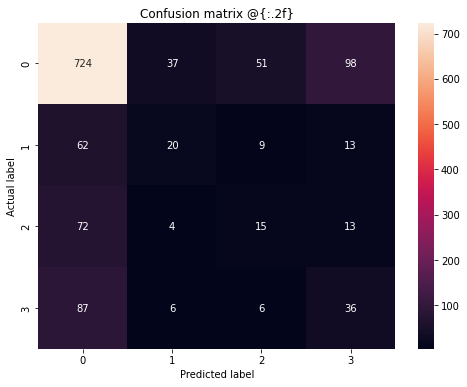

In [ ]:
plot_cm(Y_test,Y_pred_drop)

### Baseline Model with Class Weights
- Used to give equal weightage to both the classes.
- Model will penalize more for wrong prediction of minority class.

In [ ]:
model_drop.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=set_metric())

In [ ]:
class_weights = compute_class_weight('balanced', np.unique(final_data['Class']), final_data['Class'])
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 0.34412087912087913,
 1: 3.0226833976833976,
 2: 3.011057692307692,
 3: 2.3196296296296297}

In [ ]:
m_histories['CW'] = model_drop.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = 30, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_weights)

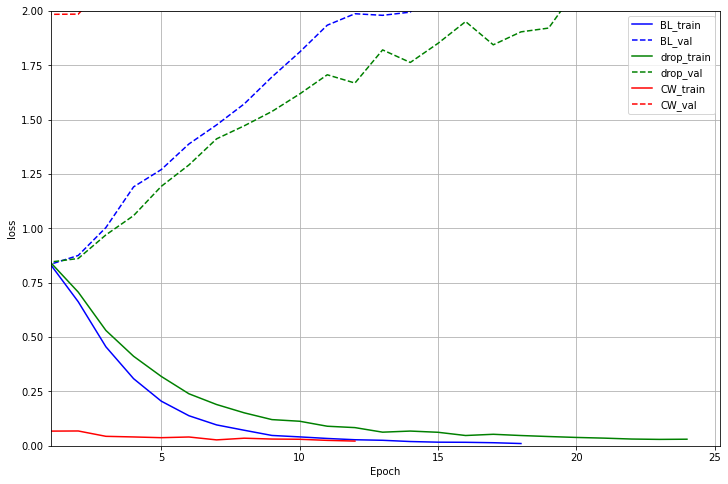

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

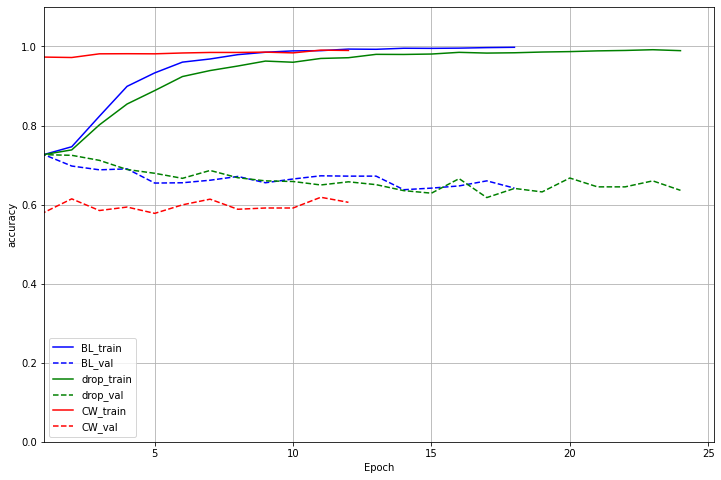

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [ ]:
Y_pred_CW = model_drop.predict([X1_test,X2_test])
Y_pred_CW = np.argmax(Y_pred_CW, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_CW))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       910
           1       0.27      0.27      0.27       104
           2       0.17      0.21      0.19       104
           3       0.25      0.27      0.26       135

    accuracy                           0.61      1253
   macro avg       0.37      0.37      0.37      1253
weighted avg       0.63      0.61      0.62      1253



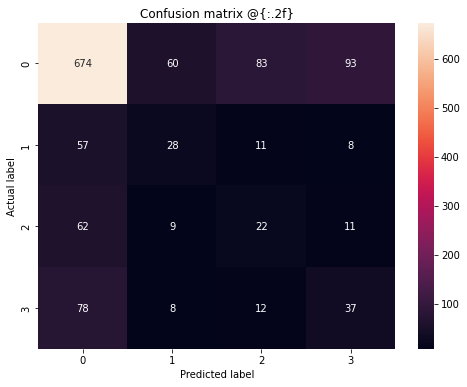

In [ ]:
plot_cm(Y_test,Y_pred_CW)

In [ ]:
# model_drop.save("model_drop.h5")
# !cp -R ./model_drop.h5 /content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/

## Transfer Learning with Glove Embedding

After carefully analysing different pre-trained embeddings, glove.twitter.27B.50d was chosen as it was trained on twitter data and that’s where our majority proportion of data is coming from. There were different dimensions available and given our problem, 50 dimension was selected by comparing different dimensions. It was also fine-tuned by unfreezing trainable layers.

In [ ]:
!cp /content/drive/MyDrive/DeepLearning/glove/glove.twitter.27B.50d.txt .

In [ ]:
file = open('glove.twitter.27B.50d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [ ]:
embedding_dim = 50
E_T = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_T[i] = embedding_vector

In [ ]:
source_input= Input(shape=(X1_train.shape[1]), name='source_input')
reply_input = Input(shape=(X2_train.shape[1]), name='reply_input')

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=X1.shape[1],
                            trainable=False)

x1 = embedding_layer_TL(reply_input)
x2 = embedding_layer_TL(source_input)
x = tf.keras.layers.concatenate([x1, x2])
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)

out = Dense(4, activation='softmax', name='output')(x)
model_TL = Model(inputs=[reply_input, source_input], outputs=[out])
model_TL.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=set_metric())

print(model_TL.summary())

In [ ]:
m_histories['TL'] =  model_TL.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = 50, batch_size=64, callbacks= [early_stopping],class_weight=class_weights)

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'accuracy')

In [ ]:
Y_pred_TL = model_TL.predict([X1_test,X2_test])
Y_pred_TL = np.argmax(Y_pred_TL, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_TL))

In [ ]:
plot_cm(Y_test,Y_pred_TL)

In [ ]:
# model.save("model_TL.h5")
# !cp -R ./model_TL.h5 /content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/

## Bidirectional LSTM

LSTM has a limitation that it can capture past dependency very well but not future dependency of a sentence. Bidirectional LSTM overcomes this issue by processing the tokens in reverse direction i.e., from end of the sentence to the beginning.

In [ ]:
embedding_dim = 50

source_input= Input(shape=(X1_train.shape[1]), name='source_input')
reply_input = Input(shape=(X2_train.shape[1]), name='reply_input')

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=X1.shape[1],
                            trainable=True)

x1 = embedding_layer_TL(reply_input)
x2 = embedding_layer_TL(source_input)
x = tf.keras.layers.concatenate([x1, x2])
x = Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))(x)
x = LSTM(32, dropout=0.5, recurrent_dropout=0.2, return_sequences=False)(x)

out = Dense(4, activation='softmax', name='output')(x)
model_BTL = Model(inputs=[reply_input, source_input], outputs=[out])
model_BTL.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=set_metric())

print(model_BTL.summary())

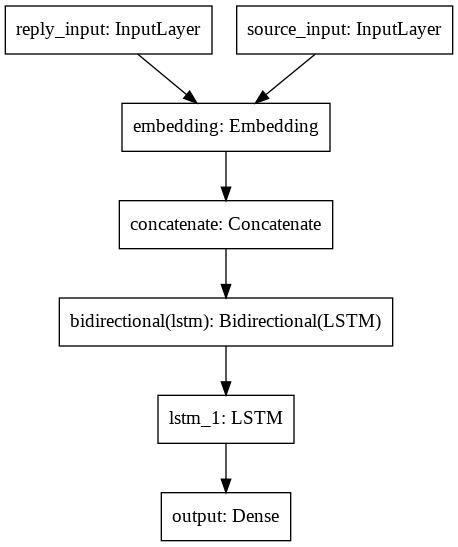

In [ ]:
tf.keras.utils.plot_model(model_BTL)

In [ ]:
m_histories['BTL'] =  model_BTL.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = 30, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_weights)

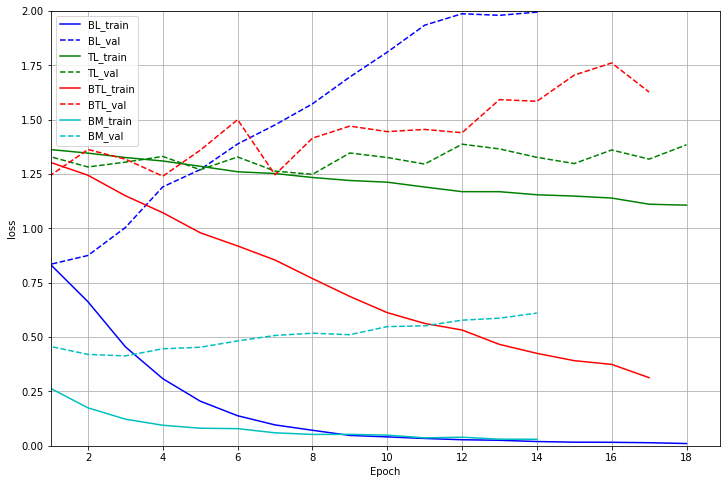

In [ ]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

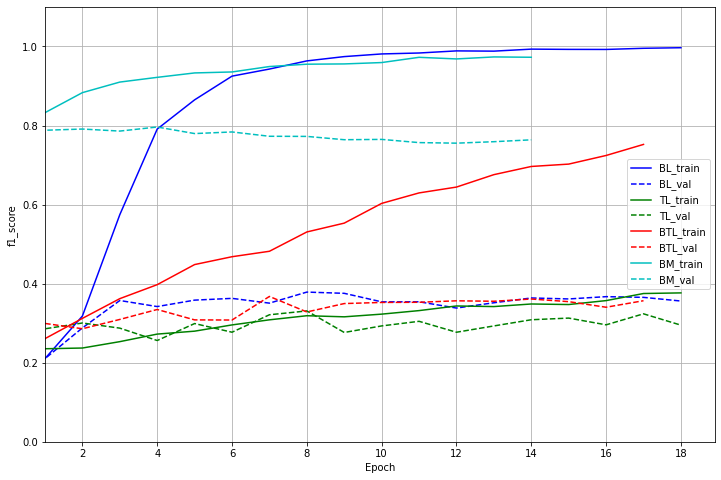

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'f1_score')

In [ ]:
Y_pred_TL = model_BTL.predict([X1_test,X2_test])
Y_pred_TL = np.argmax(Y_pred_TL, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_TL))

              precision    recall  f1-score   support

           0       0.88      0.66      0.75       910
           1       0.35      0.74      0.48       104
           2       0.45      0.64      0.53       104
           3       0.38      0.56      0.46       135

    accuracy                           0.66      1253
   macro avg       0.52      0.65      0.56      1253
weighted avg       0.74      0.66      0.68      1253



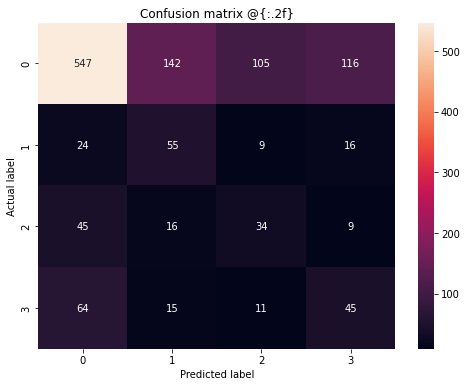

In [ ]:
plot_cm(Y_test,Y_pred_TL)

In [ ]:
# model_BTL.save("model_BTL.h5")
# !cp -R ./model_BTL.h5 /content/drive/MyDrive/DeepLearning/Assignment2/Rumour_data/

## Hyper-parameter tuning using Bayesian Optimization
- Bayesian optimization is a sequential model-based optimization (SMBO) algorithm that uses the results from the previous iteration to decide the next hyperparameter value candidates.
- It is used because it selects the hyper-parameter in an informed manner.
- It also finds the best hyper-parameters in less amount of time than grid search or random search by prioritizing hyperparameters that appear more promising from past results.

In [ ]:
!pip install scikit-optimize
#imports we know we'll need
import skopt

from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from tensorflow.python.keras import backend as K

In [ ]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=0, high=1, name='num_dense_layers')
dim_num_input_nodes1 = Integer(low=32, high=128, name='num_input_nodes1')
dim_num_input_nodes2 = Integer(low=32, high=128, name='num_input_nodes2')
dim_num_dense_nodes = Integer(low=16, high=96, name='num_dense_nodes')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes1,
              dim_num_input_nodes2,
              dim_num_dense_nodes,
              dim_adam_decay
             ]
default_parameters = [1e-2, 0, 64, 32, 13, 1e-3]

In [ ]:
# from tf.keras.optimizers import Adam
def create_model(learning_rate, num_dense_layers,num_input_nodes1,num_input_nodes2,
                 num_dense_nodes, adam_decay):
  
  
  source_input= Input(shape=(X1_train.shape[1]), name='source_input')
  reply_input = Input(shape=(X2_train.shape[1]), name='reply_input')

  embedding_layer_TL = Embedding(len(word_index) + 1,
                              embedding_dim,
                              weights=[E_T],
                              input_length=X1.shape[1],
                              trainable=True)

  x1 = embedding_layer_TL(reply_input)
  x2 = embedding_layer_TL(source_input)
  x = tf.keras.layers.concatenate([x1, x2])

  x = LSTM(num_input_nodes1, dropout=0.2, recurrent_dropout=0.25, return_sequences=True)(x)
  x = LSTM(num_input_nodes2, dropout=0.2, recurrent_dropout=0.25, return_sequences=False)(x)
  

  for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation='relu',
                        name=name
                 ))
  out = Dense(4, activation='softmax', name='output')(x)
  
  model = Model(inputs=[reply_input, source_input], outputs=[out])

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=set_metric())
  
  return model

In [ ]:
def fitting(learning_rate=1e-2, num_dense_layers =0, num_input_nodes1 =64, num_input_nodes2 =32, 
            num_dense_nodes= 13, adam_decay = 1e-3):

    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes1=num_input_nodes1,
                         num_input_nodes2=num_input_nodes2,
                         num_dense_nodes=num_dense_nodes,
                         adam_decay=adam_decay
                        )
    
    #named blackbox becuase it represents the structure
    blackbox = model.fit([X1_train,X2_train],
                         Y_train,
                         validation_data=([X1_val,X2_val], Y_val),
                         epochs = 30,
                         batch_size=32,
                         callbacks= [early_stopping],
                         class_weight=class_weights
                        )
    
    #return the validation accuracy for the last epoch.
    f1 = blackbox.history['val_f1_score'][-1]

    # Print the classification accuracy.
    print()
    print("F1: {0:.2%}".format(f1))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -f1

In [ ]:
# K.clear_session()
# tensorflow.reset_default_graph()

In [ ]:
gp_result = gp_minimize(func=fitting,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.001,
                            n_jobs=-1,
                        verbose = True
                            )

In [ ]:
gp_result.fun

-0.37590456008911133

In [ ]:
gp_result.x

[0.00011144693659375404, 0, 117, 41, 61, 0.009898951727690277]

In [ ]:
model_GO = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])

In [ ]:
m_histories['BO'] =  model_GO.fit([X1_train,X2_train], Y_train, validation_data=([X1_val,X2_val], Y_val), epochs = 30, batch_size=batch_size, callbacks= [early_stopping],class_weight=class_weights)

In [ ]:
Y_pred_GO = model_GO.predict([X1_test,X2_test])
Y_pred_GO = np.argmax(Y_pred_GO, axis = 1)

In [ ]:
print(classification_report(Y_test,Y_pred_GO))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       910
           1       0.23      0.27      0.25       104
           2       0.17      0.23      0.20       104
           3       0.26      0.28      0.27       135

    accuracy                           0.59      1253
   macro avg       0.36      0.38      0.37      1253
weighted avg       0.63      0.59      0.61      1253



# Independent Test Data

In [ ]:
independent_data = pd.read_excel('/content/drive/MyDrive/Assignment2/independent_test.xlsx')

In [ ]:
independent_data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,581063000000000000,-1,#412S4: Cristiano Ronaldo spotted in Melbourne,news,-1
1,Reply,581070000000000000,581063000000000000,RT @John Is it true?,news,query
2,Reply,581063000000000000,581063000000000000,RT @John I don't think he has come to Melbourn...,news,deny
3,Reply,581063000000000000,581063000000000000,RT @John #cristiano #spotted #melbourne I am s...,news,comment
4,Reply,581064000000000000,581063000000000000,RT @John I saw him too. I think that's true.,news,support


In [ ]:
independent_data.shape

(29, 6)

In [ ]:
independent_data['Text'] = independent_data['Text'].apply(lambda x: x.lower())
independent_data['Text'] = independent_data['Text'].apply((lambda x: re.sub('(@[a-z]+)','',x)))
independent_data['Text'] = independent_data['Text'].apply((lambda x: re.sub('(https?:\/\/.*?)(?:\s|$)','',x)))
independent_data['Text'] = independent_data['Text'].apply((lambda x: re.sub('[^a-zA-Z\s]','',x)))
independent_data['Text'] = independent_data['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
independent_data['Text'] = independent_data['Text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if len(word) > 1))

In [ ]:
# adding source to a list and map it to its replies
source = []
text_combined = []
for index, row in independent_data.iterrows():
  if (row['Type'] == "Source"):
    sId = row['Msg_ID']
    source_text = row['Text']
  if (sId == row['Source_Msg_ID']):
    source.append(source_text)

In [ ]:
independent_data = independent_data.drop(independent_data.loc[independent_data['Type']=='Source'].index)
independent_data = independent_data.reset_index(drop=True)
independent_data['Source'] = source

In [ ]:
encoder = LabelEncoder()
independent_data.insert(2,'Class_Encoded',encoder.fit_transform(independent_data['Class']))

In [ ]:
tokenizer.fit_on_texts(independent_data['Source'].values)
X3 = tokenizer.texts_to_sequences(independent_data['Source'].values)
tokenizer.fit_on_texts(independent_data['Text'].values)
X4 = tokenizer.texts_to_sequences(independent_data['Text'].values)

In [ ]:
word_index = tokenizer.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

unique tokens - 11052
vocab_size - 11053


In [ ]:
X3 = pad_sequences(X3,maxlen= 55)
X4 = pad_sequences(X4,maxlen= 55)

In [ ]:
Y = independent_data['Class_Encoded']

In [ ]:
Y_pred_IT = model_BTL.predict([X3,X4])
Y_pred_IT = np.argmax(Y_pred_IT, axis = 1)

In [ ]:
print(classification_report(Y,Y_pred_IT))

              precision    recall  f1-score   support

           0       0.38      0.62      0.48         8
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         6
           3       0.40      0.40      0.40         5

    accuracy                           0.33        24
   macro avg       0.45      0.31      0.30        24
weighted avg       0.42      0.33      0.31        24



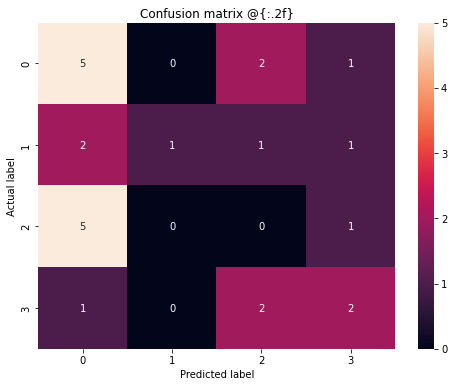

In [ ]:
plot_cm(Y,Y_pred_IT)

# Ultimate Judgement
- The best model was obtained by implementing Bidirectional LSTM which shows that there might be few sentences that have future dependencies.
- The stacking with LSTM layer helped in fetching more efficient features or words for stance classification.
- The main limitation with this dataset was that there was huge imbalance as the ‘comment’ class was very dominant and the number of observations for all the other classes were quite less i.e., less than 500
- Since deep learning based approach requires a lot of data to train, if we can get more data for deny, support, and query classes, the model would be able to perform much better.
- The drawback with all LSTM models is that it can not capture the context of the sentences as they process one token at a time.
- Transformer based models such as BERT can be used to capture the context of the sentence and improve the model's performance.